# Методы оптимизации

# Обучение с обычным SGD

Загрузим данные, создадим модель и обучим с обычным SGD.

Train size: 10000
Test size: 10000


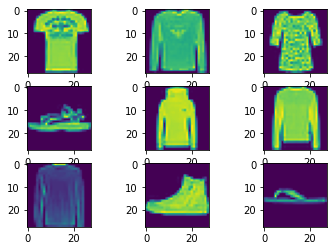

In [3]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import FashionMNIST
from matplotlib import pyplot as plt
from tqdm import tqdm

torch.manual_seed(0)
np.random.seed(0)

SUBSET_SIZE = 10000
BATCH_SIZE = 32

transform = torchvision.transforms.ToTensor()

train = FashionMNIST("mnist", train=True, transform=transform, download=True)
train = torch.utils.data.Subset(train, np.random.permutation(len(train))[:SUBSET_SIZE])
test = FashionMNIST("mnist", train=False, transform=transform, download=True)
print("Train size:", len(train))
print("Test size:", len(test))

def draw(dataset):
    images, labels = zip(*[dataset[i] for i in range(9)])
    fig, axs = plt.subplots(3, 3, squeeze=False)
    for i, image in enumerate(images):
        ax = axs[i // 3, i % 3]
        ax.imshow(image.permute(1, 2, 0))
    plt.show()

draw(train)

In [4]:
def compute_accuracy(model, loader):
    model.eval()
    n_correct = 0
    n = 0
    for images, labels in loader:
        n_correct += (model(images).argmax(dim=1) == labels).sum().item()
        n += len(images)
    return n_correct / n

Num parameters 3226
Epoch 0, loss 2.191, train 0.534, test 0.536
Epoch 1, loss 1.213, train 0.690, test 0.687
Epoch 2, loss 0.844, train 0.712, test 0.708
Epoch 3, loss 0.777, train 0.723, test 0.715
Epoch 4, loss 0.752, train 0.730, test 0.723
Epoch 5, loss 0.741, train 0.734, test 0.725
Epoch 6, loss 0.735, train 0.735, test 0.728
Epoch 7, loss 0.733, train 0.736, test 0.728
Epoch 8, loss 0.731, train 0.735, test 0.729
Epoch 9, loss 0.731, train 0.736, test 0.729
Weights norm 3.8519341945648193


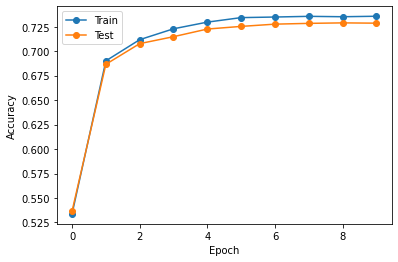

In [13]:
def get_model():
    torch.manual_seed(0)
    return torch.nn.Sequential(
        torch.nn.Conv2d(1, 4, 3, stride=2),
        torch.nn.ReLU(),
        torch.nn.Conv2d(4, 8, 3, stride=2),
        torch.nn.ReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(288, 10)
    )

def run(model, optimizer, epochs=10, scheduler=None):
    print("Num parameters", sum(map(torch.numel, model.parameters())))
    criterion = torch.nn.CrossEntropyLoss()
    loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, drop_last=True)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
    test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)
    train_accuracies = []
    test_accuracies = []
    for epoch in range(epochs):
        model.train()
        losses = []
        for images, labels in loader:
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
        model.eval()
        train_accuracy = compute_accuracy(model, loader)
        test_accuracy = compute_accuracy(model, test_loader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch}, loss {np.mean(losses):.3f}, train {train_accuracy:.3f}, test {test_accuracy:.3f}")
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(np.mean(losses))
            else:
                scheduler.step()
    print("Weights norm", torch.linalg.norm(torch.concat([p.flatten() for p in model.parameters()])).item())
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(train_accuracies, label="Train", marker="o")
    plt.plot(test_accuracies, label="Test", marker="o")
    plt.legend()
    plt.show()

model = get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        
run(model, optimizer)

При обучении с обычным SGD модель достигла точности 72.9% на тестовом корпусе. Попробуем улучшить.

# Улучшения

**Задание 1**. Примените `torch.optim.RMSprop`. Получите точность на test не меньше 82%.

Num parameters 3226
Epoch 0, loss 0.678, train 0.806, test 0.789
Epoch 1, loss 0.492, train 0.832, test 0.807
Epoch 2, loss 0.453, train 0.837, test 0.813
Epoch 3, loss 0.436, train 0.844, test 0.817
Epoch 4, loss 0.427, train 0.846, test 0.820
Epoch 5, loss 0.422, train 0.847, test 0.820
Epoch 6, loss 0.420, train 0.847, test 0.821
Epoch 7, loss 0.418, train 0.847, test 0.821
Epoch 8, loss 0.418, train 0.847, test 0.822
Epoch 9, loss 0.417, train 0.847, test 0.822
Weights norm 14.55725383758545


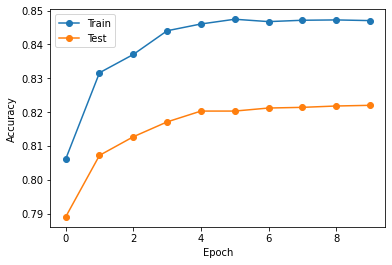

In [19]:
model = get_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
        
run(model, optimizer)

**Задание 2.** Примените `torch.optim.Adam`. Получите точность на test не менее 83%.

Num parameters 3226
Epoch 0, loss 0.691, train 0.828, test 0.814
Epoch 1, loss 0.457, train 0.847, test 0.829
Epoch 2, loss 0.412, train 0.852, test 0.827
Epoch 3, loss 0.387, train 0.861, test 0.838
Epoch 4, loss 0.375, train 0.869, test 0.844
Epoch 5, loss 0.367, train 0.870, test 0.845
Epoch 6, loss 0.364, train 0.871, test 0.845
Epoch 7, loss 0.362, train 0.871, test 0.844
Epoch 8, loss 0.360, train 0.871, test 0.844
Epoch 9, loss 0.360, train 0.871, test 0.844
Weights norm 13.847359657287598


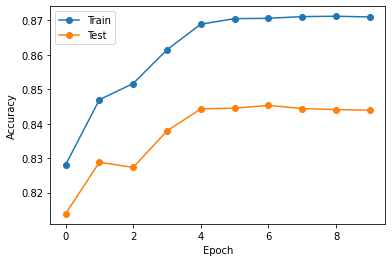

In [20]:
model = get_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

run(model, optimizer)

**Задание 3**. Примените momentum SGD. Получите точность на test не меньше 82%.

Num parameters 3226
Epoch 0, loss 1.003, train 0.785, test 0.775
Epoch 1, loss 0.537, train 0.817, test 0.804
Epoch 2, loss 0.483, train 0.835, test 0.813
Epoch 3, loss 0.461, train 0.834, test 0.811
Epoch 4, loss 0.449, train 0.839, test 0.821
Epoch 5, loss 0.442, train 0.846, test 0.823
Epoch 6, loss 0.439, train 0.844, test 0.823
Epoch 7, loss 0.437, train 0.844, test 0.823
Epoch 8, loss 0.436, train 0.844, test 0.824
Epoch 9, loss 0.435, train 0.844, test 0.824
Weights norm 6.101940631866455


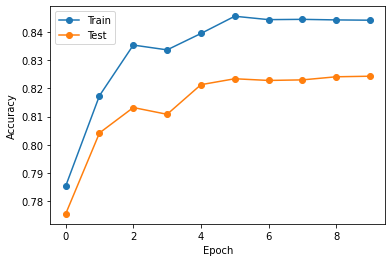

In [21]:
model = get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        
run(model, optimizer)

**Задание 4.** Примените Nesterov momentum. Получилось ли увеличить точность на train/test?

Num parameters 3226
Epoch 0, loss 0.965, train 0.794, test 0.783
Epoch 1, loss 0.523, train 0.817, test 0.803
Epoch 2, loss 0.476, train 0.838, test 0.819
Epoch 3, loss 0.453, train 0.839, test 0.819
Epoch 4, loss 0.441, train 0.842, test 0.823
Epoch 5, loss 0.435, train 0.848, test 0.827
Epoch 6, loss 0.431, train 0.848, test 0.826
Epoch 7, loss 0.430, train 0.848, test 0.827
Epoch 8, loss 0.428, train 0.848, test 0.827
Epoch 9, loss 0.428, train 0.848, test 0.827
Weights norm 6.0459208488464355


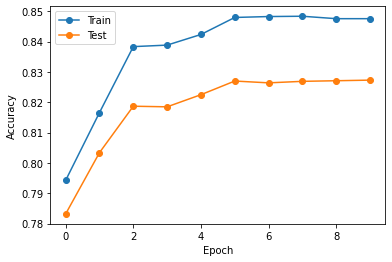

In [22]:
model = get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
        
run(model, optimizer)

**Задание 5** Попробуйте добиться точности 83.5% на test используя momentum SGD и `torch.optim.lr_scheduler.StepLR` для изменения learning rate в процессе обучения.

Num parameters 3226
Epoch 0, loss 0.793, train 0.802, test 0.789
Epoch 1, loss 0.498, train 0.828, test 0.812
Epoch 2, loss 0.446, train 0.843, test 0.824
Epoch 3, loss 0.419, train 0.853, test 0.831
Epoch 4, loss 0.405, train 0.858, test 0.834
Epoch 5, loss 0.397, train 0.858, test 0.835
Epoch 6, loss 0.393, train 0.860, test 0.835
Epoch 7, loss 0.391, train 0.859, test 0.835
Epoch 8, loss 0.390, train 0.859, test 0.835
Epoch 9, loss 0.389, train 0.859, test 0.836
Weights norm 8.744531631469727


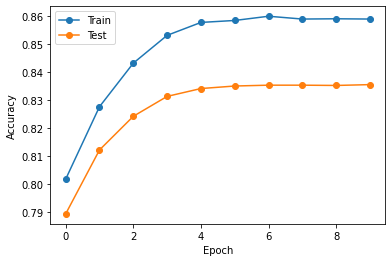

In [64]:
model = get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=.09, momentum=0.7)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, 0.9)
        
run(model, optimizer, scheduler=scheduler)

**Выводы:**
1. Какой optimizer показал себя лучше?
2. Какие параметры сильнее всего влияли на обучение?
3. Помог ли scheduler? Насколько?